In [452]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm


from scsavailability import features as feat, model as md, plotting as pt

In [2]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201123.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-2511.csv')
fa = pd.read_csv(path + 'scs_tote_matched.csv')

In [4]:
at = feat.pre_process_AT(at)

Running: Function "pre_process_AT" (id=2892608721680) was called 1 times


In [5]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=2892608721968) was called 1 times


In [6]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

Running: Function "preprocess_faults" (id=2892608722256) was called 1 times
duplicated location faults removed - max duration kept


C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = pd.to_timedelta(fa['Duration'].str.slice(start=2))
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = fa['Duration'].dt.total_seconds()


In [462]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

Time shifted by 0m


In [495]:
fa_sel = feat.fault_select(fa_floor, select_level = 'Tote Colour', selection = ['Blue','Both'])

fa_agg = feat.faults_aggregate(fa_sel,fault_agg_level= 'code', agg_type = 'count')

Running: Function "faults_aggregate" (id=2892608722832) was called 56 times


In [496]:
av_sel,at_sel = feat.av_at_select(av, at, remove_high_AT = True)

av_agg = feat.aggregate_availability(av_sel, agg_level = None)
at_agg = feat.aggregate_totes(at_sel, agg_level = None)

Running: Function "aggregate_availability" (id=2892608723264) was called 55 times


In [497]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, target = 'Blue Tote Loss',faults=True, totes = True, agg_level = None,remove_0=True)

Datasets merged


In [498]:
df.head(3)

,timestamp,Blue Tote Loss,C05,C0501STA002,C0501STA012,C0502ACH023,C0502RDC040,C0502STA024,C0502STA026,C0502STA030,...,C36,C38,C40,C42,C44,C46,C48,C50,SCSM22,TOTES
0,2020-11-18 11:00:00,0.165485,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,57.146915
1,2020-11-18 12:00:00,0.134278,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,58.247505
2,2020-11-18 13:00:00,0.152506,4,0,0,0,0,0,0,0,...,0,1,0,0,3,0,0,0,5,58.786807


In [499]:
#df = df[df['TOTES']<60].reset_index(drop=True)

In [500]:
X,y = md.gen_feat_var(df)
y= 1-y

In [503]:
X_train, X_test, y_train, y_test = md.split(X,y,test_size=0.3,random_state=42)

#RF_mdl,predictions_RF=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mse', max_depth=None, dtree=False)

#Linear_mdl,predictions_LM,Coeff = md.run_LR_model(X_train, X_test, y_train, y_test)

#XGB_mdl,predictions_XGB,Importance_XGB = md.run_XGB_model(X_train, X_test, y_train, y_test)

maxf = None


#X_sel_rf = md.select_features(X, y, RF_mdl, thres = -np.inf, max_feat = maxf)

#X_sel_lm = md.select_features(X, y, Linear_mdl, thres = -np.inf, max_feat = maxf)

#X_sel_XGB = md.select_features(X, y, XGB_mdl, thres = -np.inf, max_feat = maxf)

#X_train, X_test, y_train, y_test = md.split(X_sel_lm,y,test_size=0.3,random_state=42)

#Linear_mdl,predictions_LM,Coeff = md.run_LR_model(X_train, X_test, y_train, y_test)

model = sm.OLS(y_train,X_train)
results = model.fit()
print(results.summary())

Xnew = sm.add_constant(X_test)
y_prediction =  model.predict(X_test)

#cv_R2 = md.cross_validate_r2(Linear_mdl, X_sel_lm, y, n_folds = 10, shuffle = True, random_state = 101)

#cv_R2 = md.cross_validate_r2(RF_mdl, X_sel_rf, y, n_folds = 10, shuffle = True, random_state = 101)

#cv_R2 = md.cross_validate_r2(XGB_mdl, X_sel_XGB, y, n_folds = 10, shuffle = True, random_state = 101)

                            OLS Regression Results                            
Dep. Variable:         Blue Tote Loss   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                nan
Time:                        11:20:33   Log-Likelihood:                 2801.0
No. Observations:                  83   AIC:                            -5436.
Df Residuals:                       0   BIC:                            -5235.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
C05             0.0044        inf          0      

ValueError: shapes (83,468) and (36,468) not aligned: 468 (dim 1) != 36 (dim 0)

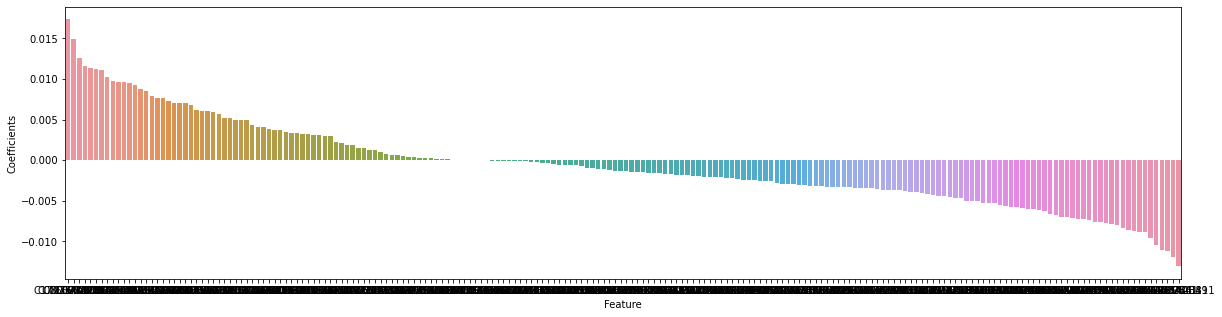

In [450]:
plt.figure(figsize=(20,5))
sns.barplot(data=Coeff, x='Feature',y = 'Coefficients')

In [429]:
X_sel_lm

,C0502STA030,C0502STA044,C0502STA049,C0601STA005,C0602ACH023,C0602RDC036,C0602STA026,C0602STA030,C0602STA034,C0602STA049,...,C2303BCH220,C2303BCL151,C2303STA080,C2303STA222,C38,C40,C42,C46,C50,TOTES
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,57.146915
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58.247505
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,58.786807
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,65.328935
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,64.182711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,28.967894
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,40.447955
116,0,0,0,0,0,5,0,0,0,0,...,0,1,1,0,6,6,5,9,0,47.532407
117,0,0,0,1,0,4,0,0,0,0,...,0,0,0,0,0,9,1,0,0,44.817674


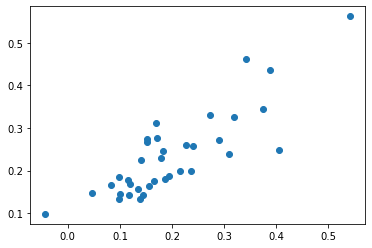

In [430]:
plt.scatter(predictions_LM,y_test)

In [451]:
Linear_mdl.intercept_

0.2741135292590805

In [18]:
#Coeff.to_excel("Coefficients.xlsx")